# Problem Statement

I have written my own data retrieval python program that retrieves data from Land Transport Authority (LTA) DataMall Bus Arrival API (https://datamall.lta.gov.sg/). The program collects data from the API every minute for a specific bus route and appends the results into a CSV file.

Given this dataset, can we capture the seasonality and patterns that is present and predict the travel duration between two stops accurately using Machine Learning (ML) algorithms?

In [71]:
import pandas as pd

csv_file_path = '../data-retriever/data/972-16102021.csv'

#NEW API SCHEMA 2021
#Origin, Destination, ETA, Lat, Long, Visit Number, Load, Feature, Type, Current Stop, Next Stop, Service, Current Time
new_col =  ['origin', 'dest', 'eta', 'lat', 'long', 'visit_num', 'load', 'feature', 'type', 'current_stop', \
            'next_stop', 'service', 'current_time', 'eta2']

df = pd.read_csv(csv_file_path, index_col=False, names = new_col)


# Let's take a brief look at our dataset! 

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70208 entries, 0 to 70207
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   origin        69988 non-null  float64
 1   dest          69988 non-null  float64
 2   eta           69988 non-null  object 
 3   lat           69988 non-null  float64
 4   long          69988 non-null  float64
 5   visit_num     69988 non-null  float64
 6   load          69988 non-null  object 
 7   feature       69988 non-null  object 
 8   type          69988 non-null  object 
 9   current_stop  70208 non-null  int64  
 10  next_stop     68872 non-null  float64
 11  service       70208 non-null  int64  
 12  current_time  70208 non-null  object 
 13  eta2          66784 non-null  object 
dtypes: float64(6), int64(2), object(6)
memory usage: 7.5+ MB


# Handling NaN values in our dataset
Oh? We have some NaN values in our next_stop column, let's dig deep to find out why!

In [73]:
df.loc[df['next_stop'].isnull()]

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,next_stop,service,current_time,eta2
51,45009.0,45009.0,2021-10-16T17:28:29+08:00,1.381010,103.763481,1.0,SEA,WAB,DD,44639,NaN,972,2021-10-16 17:29:30.351876+08:00,2021-10-16T17:45:16+08:00
103,45009.0,45009.0,2021-10-16T17:45:14+08:00,1.384054,103.770100,1.0,SEA,WAB,DD,44639,NaN,972,2021-10-16 17:30:33.522516+08:00,2021-10-16T17:52:29+08:00
155,45009.0,45009.0,2021-10-16T17:44:50+08:00,1.384283,103.770362,1.0,SEA,WAB,DD,44639,NaN,972,2021-10-16 17:31:36.415052+08:00,2021-10-16T17:52:22+08:00
207,45009.0,45009.0,2021-10-16T17:44:59+08:00,1.384283,103.770362,1.0,SEA,WAB,DD,44639,NaN,972,2021-10-16 17:32:39.650525+08:00,2021-10-16T17:52:20+08:00
259,45009.0,45009.0,2021-10-16T17:44:42+08:00,1.388874,103.770270,1.0,SEA,WAB,DD,44639,NaN,972,2021-10-16 17:33:42.548846+08:00,2021-10-16T17:52:10+08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69999,45009.0,45009.0,2021-10-17T12:52:41+08:00,1.382004,103.763018,1.0,SEA,WAB,DD,44639,NaN,972,2021-10-17 12:53:07.074234+08:00,2021-10-17T13:05:09+08:00
70051,45009.0,45009.0,2021-10-17T12:52:41+08:00,1.382004,103.763018,1.0,SEA,WAB,DD,44639,NaN,972,2021-10-17 12:53:07.073783+08:00,2021-10-17T13:05:09+08:00
70103,45009.0,45009.0,2021-10-17T12:52:41+08:00,1.382004,103.763018,1.0,SEA,WAB,DD,44639,NaN,972,2021-10-17 12:54:04.834979+08:00,2021-10-17T13:05:09+08:00
70155,45009.0,45009.0,2021-10-17T12:52:46+08:00,1.381042,103.763421,1.0,SEA,WAB,DD,44639,NaN,972,2021-10-17 12:54:09.155655+08:00,2021-10-17T13:05:02+08:00


After investigating further by taking a look at our route file, it turns out that this bus service is a loop service (starting and ending on the same stop). Hence, the API does not distinguish between the arrival time at the starting and ending stop, returning only the ETA of the starting stop. 

In short, it is safe to drop these rows!

In [74]:
df = df.dropna()
df.reset_index(drop=True, inplace=True)

# Let's do some calculations and create new columns!

## Extracting information from datetime fields

We can extract some data from the datetime fields which can be used for analysis or feature engineering.

In [75]:
#Convert to eta column into a datetime field
df['eta'] = pd.to_datetime(df['eta'])
df['eta2'] = pd.to_datetime(df['eta2'])
df['current_time'] = pd.to_datetime(df['current_time'])

#Extract hour from current_time field
df['hour'] = df['current_time'].dt.hour

#Extract day of week from current_time field
df['day'] = df['current_time'].dt.dayofweek

df.head()

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,next_stop,service,current_time,eta2,hour,day
0,45009.0,45009.0,2021-10-16 17:32:41+08:00,0.0,0.0,1.0,SEA,WAB,DD,44791,44801.0,972,2021-10-16 17:29:27.636999+08:00,2021-10-16 17:47:39+08:00,17,5
1,45009.0,45009.0,2021-10-16 17:33:35+08:00,0.0,0.0,1.0,SEA,WAB,DD,44801,44861.0,972,2021-10-16 17:29:27.694664+08:00,2021-10-16 17:48:35+08:00,17,5
2,45009.0,45009.0,2021-10-16 17:34:27+08:00,0.0,0.0,1.0,SEA,WAB,DD,44861,44811.0,972,2021-10-16 17:29:27.730226+08:00,2021-10-16 17:49:27+08:00,17,5
3,45009.0,45009.0,2021-10-16 17:35:24+08:00,0.0,0.0,1.0,SEA,WAB,DD,44811,44821.0,972,2021-10-16 17:29:27.765854+08:00,2021-10-16 17:50:24+08:00,17,5
4,45009.0,45009.0,2021-10-16 17:37:10+08:00,0.0,0.0,1.0,SEA,WAB,DD,44821,44661.0,972,2021-10-16 17:29:27.808618+08:00,2021-10-16 17:52:10+08:00,17,5


In [76]:
#Convert numerical data columns to Integer
df['current_stop'] = df['current_stop'].astype(int)
df['next_stop'] = df['next_stop'].astype(int)

df.head()

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,next_stop,service,current_time,eta2,hour,day
0,45009.0,45009.0,2021-10-16 17:32:41+08:00,0.0,0.0,1.0,SEA,WAB,DD,44791,44801,972,2021-10-16 17:29:27.636999+08:00,2021-10-16 17:47:39+08:00,17,5
1,45009.0,45009.0,2021-10-16 17:33:35+08:00,0.0,0.0,1.0,SEA,WAB,DD,44801,44861,972,2021-10-16 17:29:27.694664+08:00,2021-10-16 17:48:35+08:00,17,5
2,45009.0,45009.0,2021-10-16 17:34:27+08:00,0.0,0.0,1.0,SEA,WAB,DD,44861,44811,972,2021-10-16 17:29:27.730226+08:00,2021-10-16 17:49:27+08:00,17,5
3,45009.0,45009.0,2021-10-16 17:35:24+08:00,0.0,0.0,1.0,SEA,WAB,DD,44811,44821,972,2021-10-16 17:29:27.765854+08:00,2021-10-16 17:50:24+08:00,17,5
4,45009.0,45009.0,2021-10-16 17:37:10+08:00,0.0,0.0,1.0,SEA,WAB,DD,44821,44661,972,2021-10-16 17:29:27.808618+08:00,2021-10-16 17:52:10+08:00,17,5


# Calculating travel duration between two stops

Since we have the estimated time of arrival (ETA) for two bus instances that was retrieved from the API, we can calculate the travel duration that it takes for the bus to travel from the previous stop to the current stop.

In [77]:
#Calculate duration column and get results in seconds
df['duration'] = df['eta2'] - df['eta']
df['duration_seconds'] = df['duration'].dt.total_seconds()

df.head()

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,next_stop,service,current_time,eta2,hour,day,duration,duration_seconds
0,45009.0,45009.0,2021-10-16 17:32:41+08:00,0.0,0.0,1.0,SEA,WAB,DD,44791,44801,972,2021-10-16 17:29:27.636999+08:00,2021-10-16 17:47:39+08:00,17,5,0 days 00:14:58,898.0
1,45009.0,45009.0,2021-10-16 17:33:35+08:00,0.0,0.0,1.0,SEA,WAB,DD,44801,44861,972,2021-10-16 17:29:27.694664+08:00,2021-10-16 17:48:35+08:00,17,5,0 days 00:15:00,900.0
2,45009.0,45009.0,2021-10-16 17:34:27+08:00,0.0,0.0,1.0,SEA,WAB,DD,44861,44811,972,2021-10-16 17:29:27.730226+08:00,2021-10-16 17:49:27+08:00,17,5,0 days 00:15:00,900.0
3,45009.0,45009.0,2021-10-16 17:35:24+08:00,0.0,0.0,1.0,SEA,WAB,DD,44811,44821,972,2021-10-16 17:29:27.765854+08:00,2021-10-16 17:50:24+08:00,17,5,0 days 00:15:00,900.0
4,45009.0,45009.0,2021-10-16 17:37:10+08:00,0.0,0.0,1.0,SEA,WAB,DD,44821,44661,972,2021-10-16 17:29:27.808618+08:00,2021-10-16 17:52:10+08:00,17,5,0 days 00:15:00,900.0


# Unique bus stops

In [78]:
bus_stops = df['current_stop'].unique()
bus_stops

array([44791, 44801, 44861, 44811, 44821, 44661, 44611, 44701, 44691,
       44771, 44349, 44339, 44329, 44261, 40239, 40229, 40219, 40209,
       40199,  9219,  9047,  9037,  8138,  8057,  8041,  8031,  8111,
        8121,  9011,  9023,  9213, 40191, 40201, 40211, 40221, 40231,
       44269, 44321, 44331, 44341, 44779, 44699, 44709, 44619, 44669,
       44829, 44819, 44869, 44809, 44799, 44649])

<AxesSubplot:xlabel='current_time', ylabel='duration_seconds'>

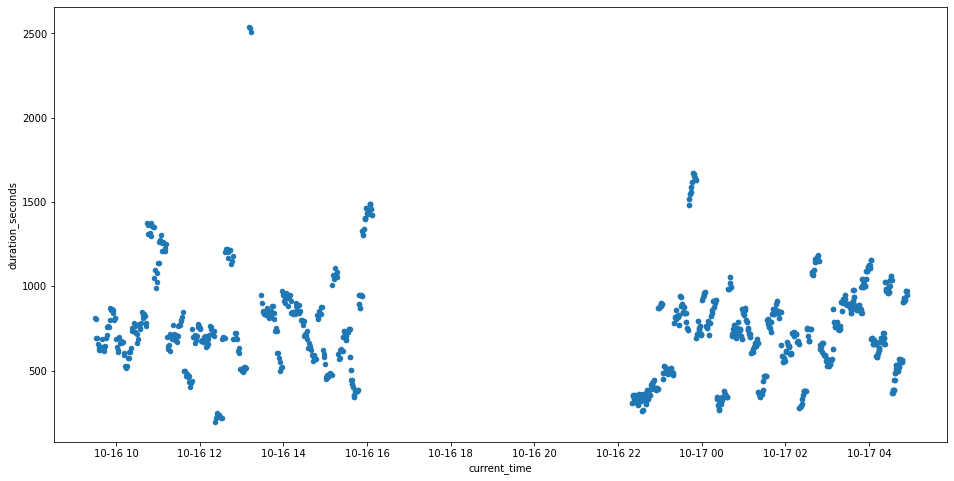

In [84]:
target_stop = df.loc[df['current_stop'] == 44269]

target_stop.plot.scatter(x='current_time', y='duration_seconds',figsize=(16,8))

## Scatter plot of Hour of the day against Travel Duration (seconds)

<AxesSubplot:xlabel='hour', ylabel='duration_seconds'>

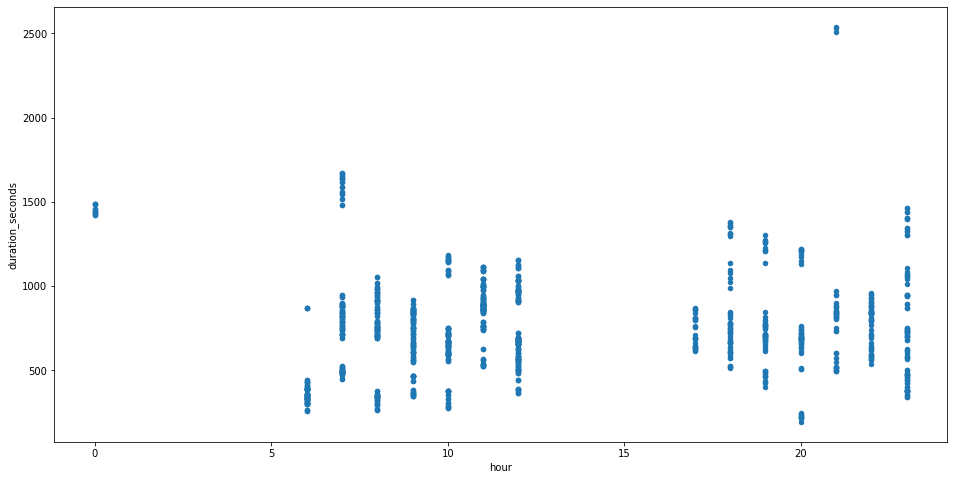

In [85]:
target_stop.plot.scatter(x='hour', y='duration_seconds',figsize=(16,8))

## Scatter plot of Day of week (e.g. Mon, Tues, Wed) against Travel Duration (seconds)

<AxesSubplot:xlabel='day', ylabel='duration_seconds'>

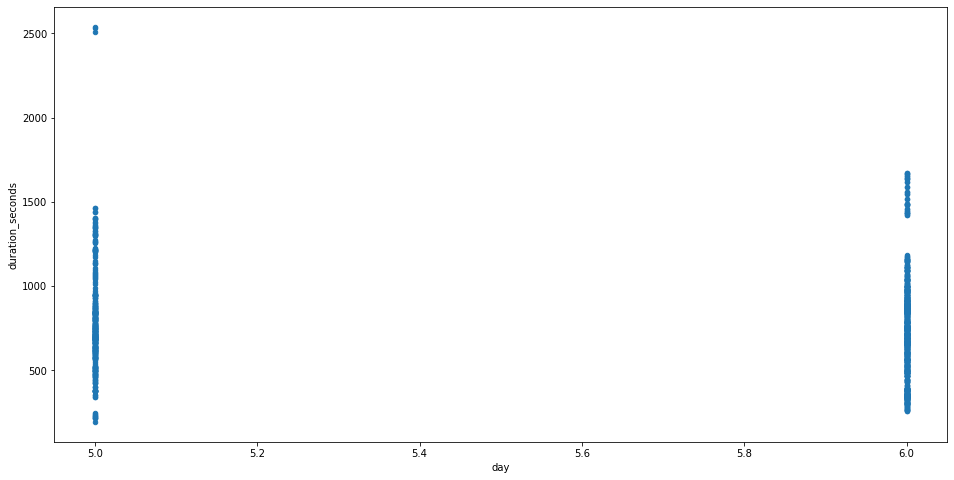

In [100]:
target_stop.plot.scatter(x='day', y='duration_seconds',figsize=(16,8))

In [101]:
df['load'].unique()

array(['SEA', 'SDA'], dtype=object)

## Plot of Bus Load (Seating) vs Travel Duration

<AxesSubplot:>

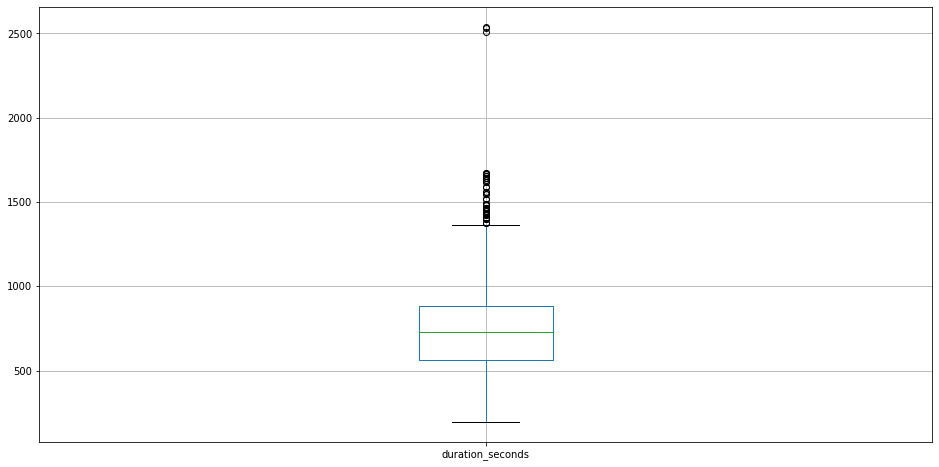

In [102]:
target_stop.loc[target_stop['load'] == 'SEA'].boxplot(column='duration_seconds',figsize=(16,8))

## Plot of Bus Load (Standing) vs Travel Duration

<AxesSubplot:>

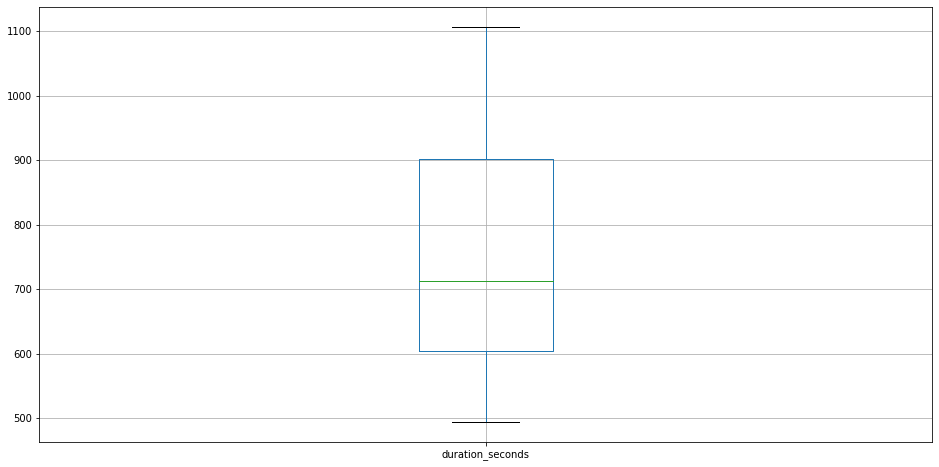

In [103]:
target_stop.loc[target_stop['load'] == 'SDA'].boxplot(column='duration_seconds',figsize=(16,8))

In [104]:
df['type'].unique()

array(['DD', 'SD'], dtype=object)

## Plot of Bus Type (Single-deck) vs Travel Duration

<AxesSubplot:>

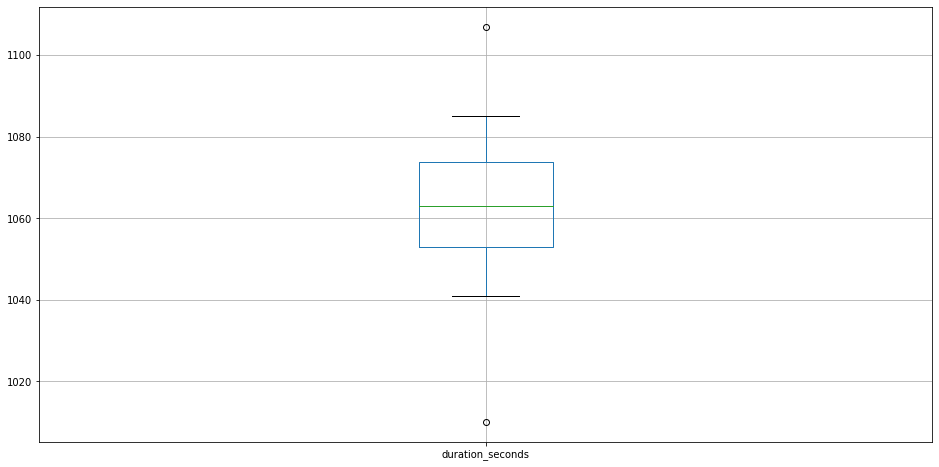

In [105]:
target_stop.loc[target_stop['type'] == 'SD'].boxplot(column='duration_seconds',figsize=(16,8))

## Plot of Bus Type (Double-deck) vs Travel Duration

Does the type of bus affects the travel duration?

<AxesSubplot:>

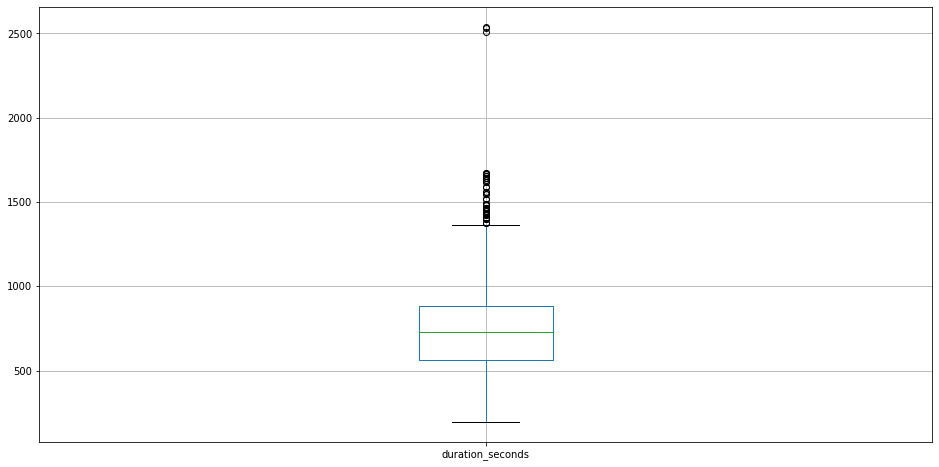

In [106]:
target_stop.loc[target_stop['type'] == 'DD'].boxplot(column='duration_seconds',figsize=(16,8))

# Summary

## Findings
1. Time of the day shows a non-linear correlation to the travel duration between two stops
